## Health Care for All Case Study using Pandas

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder  ##. better to use dummy from pandas 
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50
## Install xlrd package to load Excel files
# conda install openpyxl
## conda install xlrd

<b> loading cleaning data 

In [86]:
hk_df=pd.read_csv("hk_df_cleaned.csv")

In [87]:
hk_df.columns

Index(['state', 'gender', 'median_home_val', 'avg_fam_income',
       'avg_household_income', 'med_fam_income', 'median_household_income',
       'hvp1', 'per_capita_income', 'pobc2', 'avggift', 'domain', 'target_d'],
      dtype='object')

<b> checking correlations between numerical variables

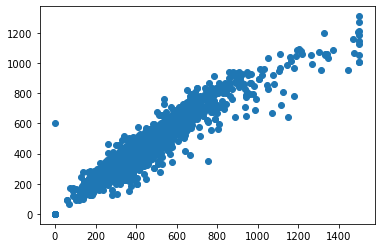

In [88]:
plt.scatter(x=hk_df['med_fam_income'], y=hk_df['avg_household_income'])
plt.show()

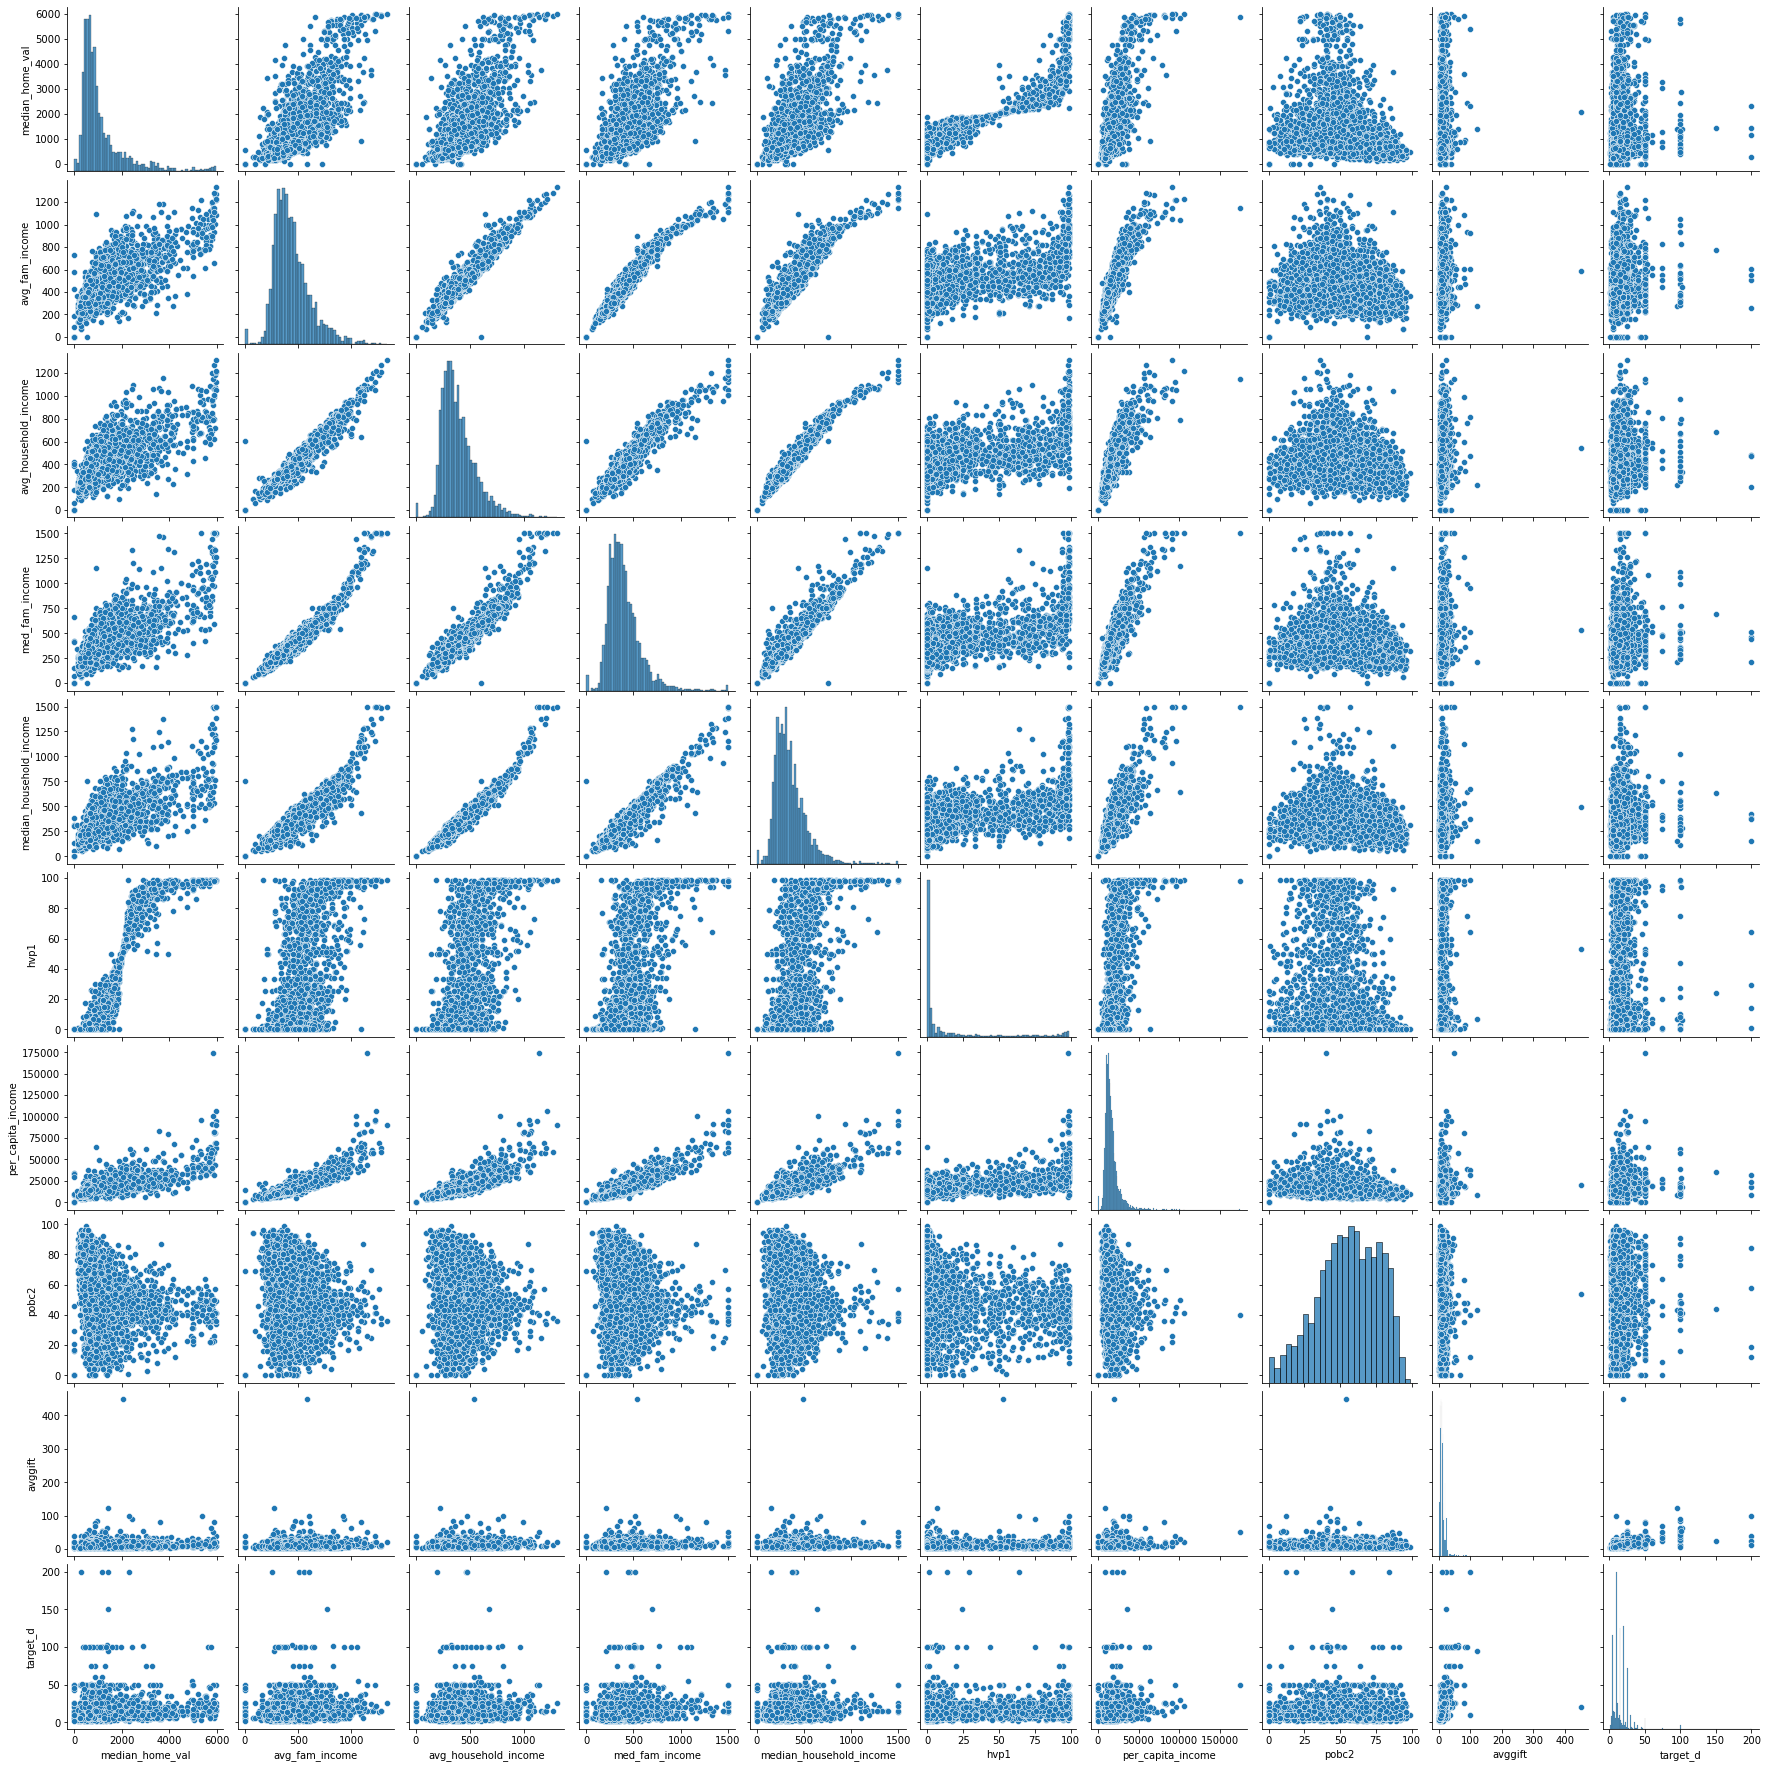

In [89]:
sns.pairplot(hk_df)

<b> plotting the correlation heatmap

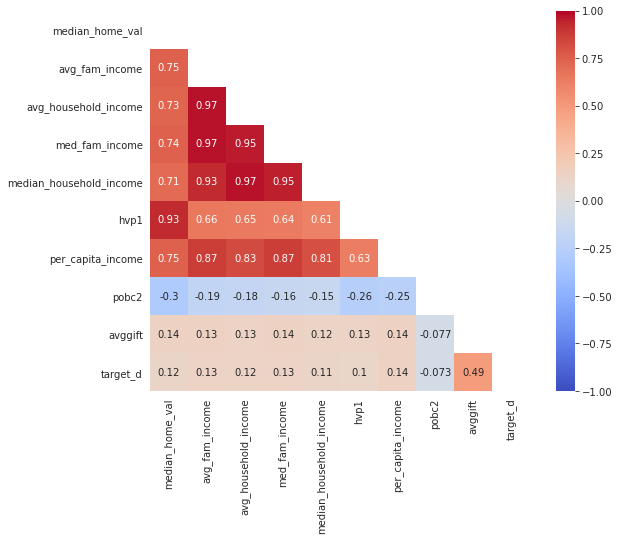

In [90]:
corr = hk_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

### Highly Correlated Columns

In [91]:
corr_matrix=hk_df.corr().abs()
upper_triangle=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
[column for column in upper_triangle.columns if any(upper_triangle[column] > 0.80)]

['avg_household_income',
 'med_fam_income',
 'median_household_income',
 'hvp1',
 'per_capita_income']

### dropping highly correlated features

In [92]:
hk_df.drop(["per_capita_income","hvp1","avg_household_income","median_household_income","med_fam_income"],axis=1,inplace=True)

In [93]:
hk_df

state  gender  median_home_val  avg_fam_income  pobc2  avggift domain  \
0       FL    Male      1159.148591           520.0     16       28     C2   
1       IL    Male       537.000000           473.0     89        5     T2   
2       FL  Female       725.000000           436.0     17        4     C2   
3       NC    Male      1159.148591           413.0     74       27     T2   
4       FL  Female       995.000000           348.0      6        6     C2   
...    ...     ...              ...             ...    ...      ...    ...   
4015    FL  Female       742.000000           470.0     37       14     S2   
4016    FL    Male       599.000000           423.0     27        9     C1   
4017    ND    Male       593.000000           299.0     70        5     S2   
4018    WI       U       564.000000           397.0     96       11     T2   
4019    MI    Male       651.000000           505.0     77        7     S2   

      target_d  
0        100.0  
1          7.0  
2          5.0  
3         38.0  
4          5.0  
...        ...  
4015      50.0  
4016      10.0  
4017       5.0  
4018      14.0  
4019       9.0  

[4020 rows x 8 columns]

array([[<AxesSubplot:title={'center':'median_home_val'}>,
        <AxesSubplot:title={'center':'avg_fam_income'}>],
       [<AxesSubplot:title={'center':'pobc2'}>,
        <AxesSubplot:title={'center':'avggift'}>],
       [<AxesSubplot:title={'center':'target_d'}>, <AxesSubplot:>]],
      dtype=object)

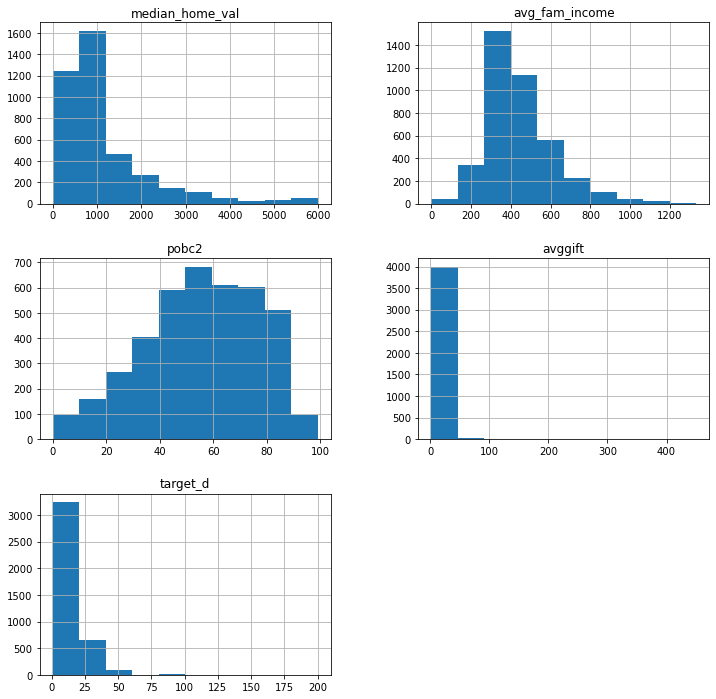

In [94]:
hk_df.hist(figsize=(12,12))

<b> checking the distribution plot

/opt/anaconda3/envs/DA/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='median_home_val', ylabel='Density'>

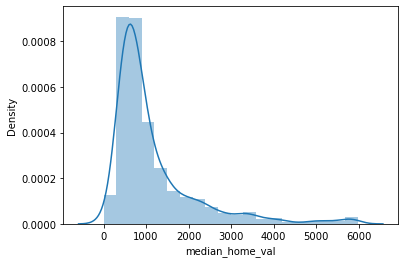

In [95]:
sns.distplot((hk_df['median_home_val']), bins=20)

## Data Transformation

Power Transformer: using power transformer to tranform the variable into normal distributionsas it is needed for modeling regression.

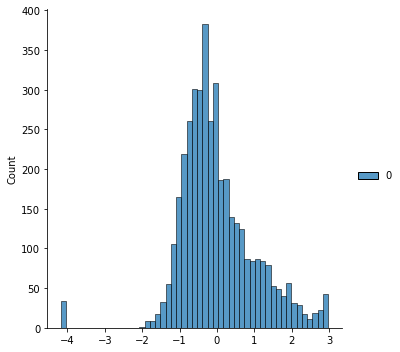

In [96]:
pt = PowerTransformer()
med_home_val_transformed=pt.fit_transform(hk_df['median_home_val'].to_numpy().reshape(-1,1))
sns.displot(med_home_val_transformed)

In [97]:
pt.lambdas_

array([0.24409374])

In [47]:
hk_df["med_home_val_transformed"]= med_home_val_transformed
hk_df.drop(["median_home_val"],axis=1,inplace=True)

In [48]:
hk_df

state  gender  avg_fam_income  pobc2  avggift domain  target_d  \
0       FL    Male           520.0     16       28     C2     100.0   
1       IL    Male           473.0     89        5     T2       7.0   
2       FL  Female           436.0     17        4     C2       5.0   
3       NC    Male           413.0     74       27     T2      38.0   
4       FL  Female           348.0      6        6     C2       5.0   
...    ...     ...             ...    ...      ...    ...       ...   
4015    FL  Female           470.0     37       14     S2      50.0   
4016    FL    Male           423.0     27        9     C1      10.0   
4017    ND    Male           299.0     70        5     S2       5.0   
4018    WI       U           397.0     96       11     T2      14.0   
4019    MI    Male           505.0     77        7     S2       9.0   

      med_home_val_transformed  
0                     0.294846  
1                    -0.636833  
2                    -0.294111  
3                     0.294846  
4                     0.095725  
...                        ...  
4015                 -0.266584  
4016                 -0.514993  
4017                 -0.526356  
4018                 -0.582535  
4019                 -0.419946  

[4020 rows x 8 columns]

## Hot coding Categorical Variables 

In [148]:
categoricals_features= hk_df.select_dtypes("object")
categoricals_features

state  gender domain
0       FL    Male     C2
1       IL    Male     T2
2       FL  Female     C2
3       NC    Male     T2
4       FL  Female     C2
...    ...     ...    ...
4015    FL  Female     S2
4016    FL    Male     C1
4017    ND    Male     S2
4018    WI       U     T2
4019    MI    Male     S2

[4020 rows x 3 columns]

In [149]:
#hk_df.state.value_counts()
#hk_df.gender.value_counts()
#hk_df.domain.value_counts()

In [150]:
categoricals_features=pd.get_dummies(categoricals_features[["gender"]], drop_first=True)
categoricals_features

gender_Male  gender_U
0               1         0
1               1         0
2               0         0
3               1         0
4               0         0
...           ...       ...
4015            0         0
4016            1         0
4017            1         0
4018            0         1
4019            1         0

[4020 rows x 2 columns]

### Predictive Modeling

<b> X Y split

In [192]:
X=hk_df.drop('target_d', axis=1)
y=hk_df.target_d

In [193]:
X=X._get_numeric_data()
X

median_home_val  avg_fam_income  pobc2  avggift
0         1159.148591           520.0     16       28
1          537.000000           473.0     89        5
2          725.000000           436.0     17        4
3         1159.148591           413.0     74       27
4          995.000000           348.0      6        6
...               ...             ...    ...      ...
4015       742.000000           470.0     37       14
4016       599.000000           423.0     27        9
4017       593.000000           299.0     70        5
4018       564.000000           397.0     96       11
4019       651.000000           505.0     77        7

[4020 rows x 4 columns]

In [194]:
## adding categorical features
#X=pd.concat([X,categorical_cols],axis=1)

In [195]:
X

median_home_val  avg_fam_income  pobc2  avggift
0         1159.148591           520.0     16       28
1          537.000000           473.0     89        5
2          725.000000           436.0     17        4
3         1159.148591           413.0     74       27
4          995.000000           348.0      6        6
...               ...             ...    ...      ...
4015       742.000000           470.0     37       14
4016       599.000000           423.0     27        9
4017       593.000000           299.0     70        5
4018       564.000000           397.0     96       11
4019       651.000000           505.0     77        7

[4020 rows x 4 columns]

array([[<AxesSubplot:title={'center':'median_home_val'}>,
        <AxesSubplot:title={'center':'avg_fam_income'}>],
       [<AxesSubplot:title={'center':'pobc2'}>,
        <AxesSubplot:title={'center':'avggift'}>]], dtype=object)

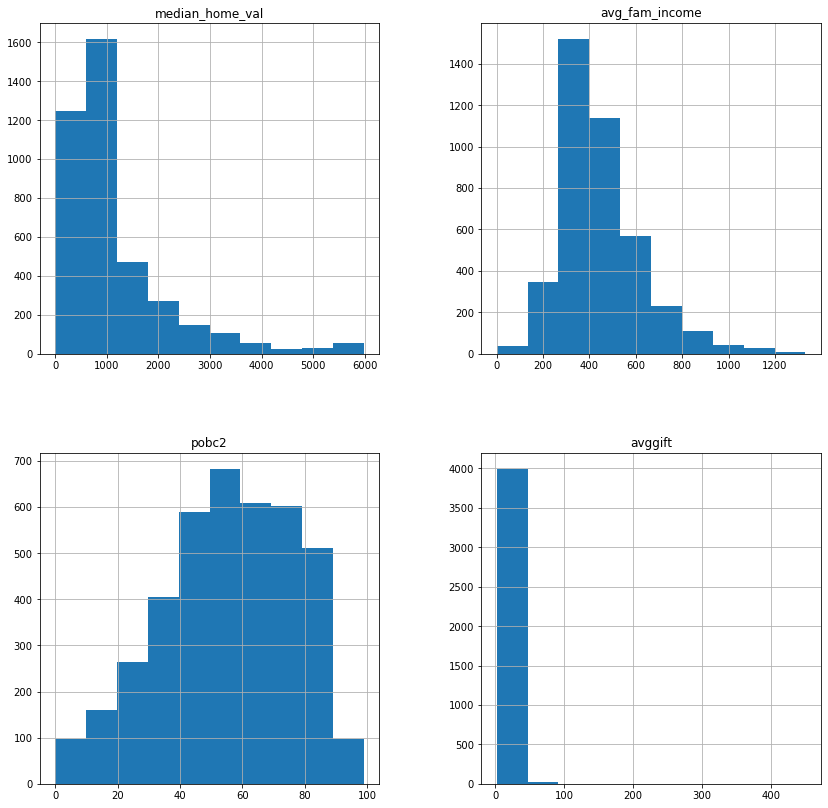

In [196]:
X.hist(figsize=(14,14))

<b>Data Splitting

In [197]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30,random_state=123)

<b> Standardize 

In [198]:
std_scaler=StandardScaler().fit(X_train)   ##. finding the parameters ( mean, variance from the training set )

X_train_scaled=std_scaler.transform(X_train)

In [215]:
X_train.shape

(2814, 4)

In [199]:
X_test_scaled=std_scaler.transform(X_test)

In [200]:
print(X_train_scaled)
print("--------")
print(X_test_scaled)

[[-0.65987862 -0.71897043  1.66154024 -0.39208054]
 [-0.50153346 -0.62656524 -0.70762673 -0.39208054]
 [ 1.00130598  0.68443342 -0.70762673 -0.30251851]
 ...
 [-0.14645646  1.08870613 -1.07926076 -0.39208054]
 [-0.83261878 -0.91533146  0.82536366 -0.21295648]
 [-0.08695707  0.91544639  1.24345195  0.3244157 ]]
--------
[[-0.62724992 -0.88067952 -0.28953844 -0.57120461]
 [-0.15029513  0.04914772 -1.59025756 -0.66076664]
 [-0.50825114 -0.83447692  0.40727538  1.220036  ]
 ...
 [-0.29040659  0.35523992 -1.12571501  0.14529164]
 [-0.56295219 -0.69586913  1.33636046 -0.30251851]
 [-0.2990436  -0.32624837 -2.10125435  0.3244157 ]]


## Apply Linear Regression

In [201]:
X.columns

Index(['median_home_val', 'avg_fam_income', 'pobc2', 'avggift'], dtype='object')

### Modeling using Statsmodels

In [202]:
X_train_const_scaled = sm.add_constant(X_train_scaled) # adding a constant

model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled) 

X_test_const_scaled = sm.add_constant(X_test_scaled) # adding a constant
predictions_test = model.predict(X_test_const_scaled) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:               target_d   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     178.5
Date:                Wed, 02 Feb 2022   Prob (F-statistic):          2.17e-136
Time:                        11:59:26   Log-Likelihood:                -10820.
No. Observations:                2814   AIC:                         2.165e+04
Df Residuals:                    2809   BIC:                         2.168e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.6046      0.213     73.095      0.0

In [203]:
predictions_test

array([11.7321949 , 12.68372844, 21.26428307, ..., 17.28295936,
       12.78686101, 17.85023666])

In [204]:
#display adjusted R-squared
print(model.rsquared_adj)

0.20149464336101663


### Modeling using Scikit Learn

Model fitting

In [205]:
model=LinearRegression()    # model
model.fit(X_train_scaled, y_train)   # model train

LinearRegression()

<b> model parameters  ( b1,b2,b3,b4)

In [206]:
model.coef_

array([-0.21522668,  1.13711148, -0.37296458,  5.45155643])

In [207]:
model.intercept_

15.60459132906894

In [208]:
#y= 1.34* avg_fam_income  -0.41 * pobc2   +5.45 * avggift  -0.48 * med_home_val_transformed  + 15.66

Making prediction

In [223]:
y_pred=model.predict(X_test_scaled)   # model prediction

y_pred_train=model.predict(X_train_scaled)

In [224]:
X

median_home_val  avg_fam_income  pobc2  avggift
0         1159.148591           520.0     16       28
1          537.000000           473.0     89        5
2          725.000000           436.0     17        4
3         1159.148591           413.0     74       27
4          995.000000           348.0      6        6
...               ...             ...    ...      ...
4015       742.000000           470.0     37       14
4016       599.000000           423.0     27        9
4017       593.000000           299.0     70        5
4018       564.000000           397.0     96       11
4019       651.000000           505.0     77        7

[4020 rows x 4 columns]

## predicting on new data

In [225]:
np.array(np.array(new_data).reshape(-1,4)).shape

(1, 4)

In [226]:
## new record 
new_data=[2000,450,18,25]
new_data_scaled=std_scaler.transform(np.array(new_data).reshape(-1,4))

In [227]:
model.predict(new_data_scaled)

array([22.77056635])

## Evaluating Model Performance

In [228]:
y_test

2160     5.0
627      4.0
2261    20.0
822     25.0
198      3.0
        ... 
2708    25.0
336      7.0
1757    38.0
1801    10.0
1499    15.0
Name: target_d, Length: 1206, dtype: float64

In [229]:
y_pred

array([11.7321949 , 12.68372844, 21.26428307, ..., 17.28295936,
       12.78686101, 17.85023666])

In [230]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

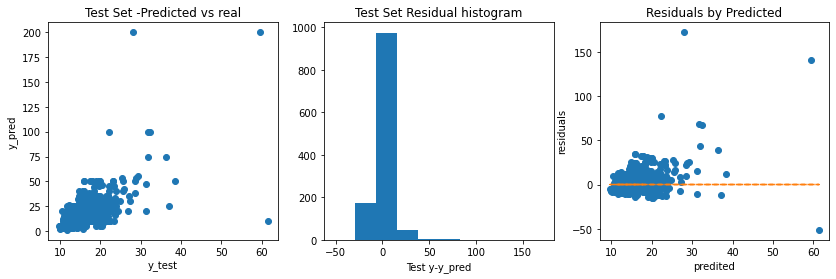

In [231]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predited")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

<b>more fancy using seaborn

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

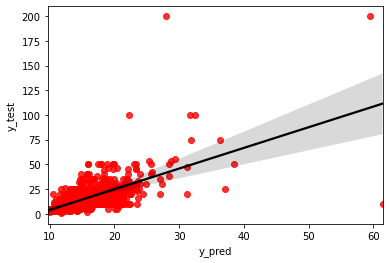

In [232]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

<b> Error metrics

In [233]:
print(mse(y_test,y_pred))
print(mae(y_test,y_pred))

110.92567732815853
5.96668460913595


In [234]:
##prediction on the train set
mse(y_train,y_pred_train)

128.01957919536835

In [235]:
R2=r2_score(y_test,y_pred)
R2

0.31257962131761696

In [236]:
R2_test=model.score(X_test_scaled,y_test)
R2_train=model.score(X_train_scaled,y_train)

## getting the number of parameters 

In [237]:
X_test.shape[1]

4

In [238]:
Adj_R2= 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Adj_R2

0.31029012796646827

#### Feature Importance

In [239]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)

In [240]:
features_importances

Attribute  Importance
3          avggift    5.451556
1   avg_fam_income    1.137111
2            pobc2    0.372965
0  median_home_val    0.215227

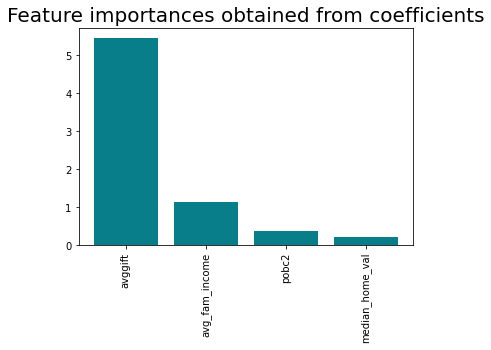

In [241]:
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

#### Write a csv

With `to_csv` 

In [ ]:
hk_df.to_csv("Data/healthcare_for_all_transformed_data.csv")